![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction to nuPlan](#introduction)
2. [Training an ML planner](#training)
3. [Simulating a planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

# Introduction to nuPlan <a name="introduction"></a>


Welcome to nuPlan! This notebook will explore the nuPlan simulation framework, training platform as well as the nuBoard metrics/scenarios visualization dashboard.

## What is nuPlan

nuPlan is the world’s first closed-loop ML-based planning benchmark for autonomous driving.

It provides a high quality dataset with 1500h of human driving data from 4 cities across the US and Asia with widely varying traffic patterns (Boston, Pittsburgh, Las Vegas and Singapore). In addition, it provides a closed-loop simulation framework with reactive agents, a training platform as well as a large set of both general and scenario-specific planning metrics.

![](https://www.nuscenes.org/static/media/framework_steps.2d4642df.png)

## Training & simulation framework

The nuPlan training and simulation framework aims to:
* create a simulation pipeline to evaluate a planner on large dataset with various scenarios
* score planner performance with common and scenario-dependent metrics
* compare planners based on measured metrics and provide intuitive visualizations
* train planners with the provided framework to allow quick implementation and iteration
* support closed-loop simulation and training

<br />

![](https://www.nuplan.org/static/media/planning_framework.ca3c2969.png)

## Scenarios in nuPlan

nuPlan aims to capture challenging yet representative scenarios from real-world encounters. This enables the benchmarking of planning systems both in expert imitation (open-loop) and reactive planning (closed-loop) settings.

These scenarios includes:
* highly interactive scenes with traffic participants (e.g. tailgating, high-velocity overtakes, double parked cars, jaywalking)
* various ego behaviors (e.g. vehicle following, yielding, lane merging) and dynamics (e.g. mixed speed profiles, abrupt braking, speed bumps, high jerk maneuvers)
* scene layouts of varied complexity (e.g. pudos, traffic/stop controlled intersections, unprotected turns) and temporary zones (e.g. construction areas)

The dataset is automatically tagged with scenario labels based on certain primitive attributes.
These scenario tags can then be used to extract representative metrics for the planner's evaluation.

Example mined scenarios in nuPlan:

| | | |
| :-: | :-: | :-: |
| Unprotected cross turn | Dense vehicle interactions | Jaywalker in front |
| ![](https://www.nuscenes.org/static/media/unprotected-cross.51feef7e.webp) | ![](https://www.nuscenes.org/static/media/dense-interactions.16de47ec.webp) | ![](https://www.nuscenes.org/static/media/jaywalker.03083823.webp) |
| Lane change | Ego at pickup/dropoff area | Ego following vehicle |
| ![](https://www.nuscenes.org/static/media/lane-change.54bfca1c.webp) | ![](https://www.nuscenes.org/static/media/pickup-dropoff.4dd1c418.webp) | ![](https://www.nuscenes.org/static/media/following-vehicle.4cacd559.webp) |

## Database

Download a database for training/simulation from [here](https://nuplan.org/nuplan#download).

| Database | Size | Duration | Num Logs | Cities | Num Scenarios | Sensor Data | Description |
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| nuplan_v1.1_mini (recommended) | 13GB | 7h | 64 | Las Vegas, Boston, Pittsburgh, Singapore | 67 | N/A | The mini split used for prototyping and testing |
| nuplan_v1.1 | 1.8TB | ~1300h | 15910 | Las Vegas, Boston, Pittsburgh, Singapore | 73 | N/A | The full dataset for training and evaluation|

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [1]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_158407/4180358289.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [11]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Training an ML planner <a name="training"></a>

## Imitation learning
In the following section we will train an ML planning policy with the aim estimate the ego's future trajectory and control the vehicle.

The policy is learned through imitation learning, a supervised learning approach in which - in the context of autonomous driving - the behavior of an expert human driver is used as a target signal to supervise the model.

## Model features & targets
A planning policy consumes a set of episodic observations and encodes them through a deep neural network to regress a future trajectory.

The observations can be historic or present ego and agent poses as well as static/dynamic map information across different map layers.<br />
These signals can be encoded through various representations, such as raster or vector format for the map signal, each with their pros and cons for each model flavor.

Using these input features the model predicts a discretized future trajectory across a fixed time horizon.<br />
The trajectory consists of a set of discrete future states (position, heading and velocity) sampled at fixed intervals which express the likelihood of the vehicle being at that state in the future.<br />
For example, a predicted trajectory may consist of 10 future poses sampled at intervals of 0.5s across a 5s horizon.

## Learning objectives
The policy is trained to maximize a set of aggregated objectives such as imitation, collision avoidance, traffic rule violation etc.<br />
Imitation is the core training objective which indicates how close the predicted trajectory is to the expert ground truth and penalizes model predictions that deviate in space and time from the demonstration.

## Training parameters

The following parameter categories define the training protocol which includes the model, metrics, objectives etc.

A working example composition of these parameters can be found in the next section.

---

### ML models

Change the training model with `model=X` where `X` is a config yaml defined in the table below. 

| Model | Description | Config |
| --- | --- | --- |
| Raster model (CNN) | Raster-based model that uses a CNN backbone to encode ego, agent and map information as raster layers<br />Any (pretrained) backbone from the TIMM library can be used (e.g. ResNet50, EfficientNetB3) | `raster_model` |
| Vector model (LaneGCN) | Vector-based model that uses a series of MLPs to encode ego and agent signals, a lane graph to encode vector-map elements and a fusion network to capture lane & agent intra/inter-interactions through attention layers<br />Implementation of LaneGCN paper ("Learning Lane Graph Representations for Motion Forecasting") | `vector_model` |
| Simple vector model | Toy vector-based model that consumes ego, agent and lane signals through a series of MLPs | `simple_vector_model` |

<br />

### Training objectives

Change the training objectives with `objective=[X, ...]` where `X` is a config yaml defined in the table below. 

| Objective | Description | Config |
| --- | --- | --- |
| Imitation objective | Penalizes the predicted trajectory that deviates from the expert demonstration | `imitation_objective` |

<br />

### Training metrics

Change the training objectives with `training_metric=[X, ...]` where `X` is a config yaml defined in the table below. 

| Metric | Description | Config |
| --- | --- | --- |
| Average displacement error | RMSE translation error across full predicted trajectory | `avg_displacement_error` |
| Average heading error | RMSE heading error across full predicted trajectory | `avg_heading_error` |
| Final displacement error | L2 error of predicted trajectory's final pose translation | `final_displacement_error` |
| Final heading error | L2 error of predicted trajectory's final pose heading | `final_heading_error` |

## Prepare the training config

In [12]:
# Location of path with all training configs
CONFIG_PATH = '../nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
SAVE_DIR = Path(tempfile.gettempdir()) / 'tutorial_nuplan_framework'  # optionally replace with persistent dir
EXPERIMENT = 'training_raster_experiment'
JOB_NAME = 'train_default_raster'
LOG_DIR = str(SAVE_DIR / EXPERIMENT / JOB_NAME)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    f'job_name={JOB_NAME}',
    'py_func=train',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=10',
    'data_loader.params.batch_size=8',
    'data_loader.params.num_workers=8',
])


(raylet) [2023-04-16 12:57:40,740 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 947613696; capacity: 490577010688. Object creation will fail if spilling is required.


## Launch tensorboard for visualizing training artifacts

In [4]:
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

## Launch training (within the notebook)

In [ ]:
from nuplan.planning.script.run_training import main as main_train

# Run the training loop, optionally inspect training artifacts through tensorboard (above cell)
main_train(cfg)

Global seed set to 0


2023-04-16 12:57:45,992 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:17}  Building experiment folders...
2023-04-16 12:57:45,992 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:17}  Building experiment folders...
2023-04-16 12:57:45,992 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:19}  Experimental folder: /tmp/tutorial_nuplan_framework/training_raster_experiment/train_default_raster/2023.04.16.12.57.45
2023-04-16 12:57:45,992 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:19}  Experimental folder: /tmp/tutorial_nuplan_framework/training_raster_experiment/train_default_raster/2023.04.16.12.57.45
2023-04-16 12:57:45,992 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-04-16 12:57:45,992 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_po

2023-04-16 12:57:51,048	INFO worker.py:1553 -- Started a local Ray instance.


2023-04-16 12:57:52,007 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-04-16 12:57:52,007 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-04-16 12:57:52,008 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-04-16 12:57:52,008 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-04-16 12:57:52,008 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-04-16 12:57:52,008 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py

Ray objects:   0%|                                       | 0/12 [00:00<?, ?it/s]

## Launch training (command line - alternative)

A training experiment with the above same parameters can be launched alternatively with:
```
$ python nuplan/planning/script/run_training.py \
    experiment_name=raster_experiment \
    py_func=train \
    +training=training_raster_model \
    scenario_builder=nuplan_mini \
    scenario_filter.limit_total_scenarios=500 \
    lightning.trainer.params.max_epochs=10 \
    data_loader.params.batch_size=8 \
    data_loader.params.num_workers=8
```

# Simulating a planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Measuring success
Measuring the success of a planning task and comparing various planning policies is a complicated effort that involves defining metrics across different vertical dimensions and scenario categories.<br />
These metrics include indicators such as vehicle dynamics, traffic rule violations, expert imitation, navigation success etc.<br />
Overall, they aim to capture the policy's ability to control the autonomous vehicle safely yet efficiently without compromising the passenger's comfort.

## Simulation parameters

### Planners

Change the planner model with `planner=X` where `X` is a config yaml defined in the table below. 

| Planner | Description | Config |
| --- | --- | --- |
| Simple Planner | Naive planner that only plans a straight path | `simple_planner` |
| ML Planner | Learning-based planner trained using the nuPlan training framework (see previous section) | `ml_planner` |

## Prepare the simulation config

In [6]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Select the planner and simulation challenge
PLANNER = 'simple_planner'  # [simple_planner, ml_planner]
CHALLENGE = 'open_loop_boxes'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=10',  # use 10 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'simulation_simple_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    f'planner={PLANNER}',
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

(raylet) [2023-04-15 22:02:44,408 E 158665 158699] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-00-52_614300_158407 is over 95% full, available space: 770404352; capacity: 490577010688. Object creation will fail if spilling is required.


## Launch simulation (within the notebook)

Global seed set to 0


2023-04-15 22:02:46,596 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-04-15 22:02:46,973 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-04-15 22:02:47,140 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-04-15 22:02:47,141 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:129}  Ray is running, we will shut it down before starting again!
2023-04-15 22:02:49,386 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:75}  Starting ray local!


2023-04-15 22:02:51,731	INFO worker.py:1553 -- Started a local Ray instance.


2023-04-15 22:02:52,646 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-04-15 22:02:52,646 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-04-15 22:02:52,646 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-04-15 22:02:52,647 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:29}  Building experiment folders...
2023-04-15 22:02:52,647 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  

	Folder where all results are stored: /tmp/tutorial_nuplan_framework/simulation_simple_experiment/open_loop_boxes/2023.04.15.22.02.46

2023-04-15 22:02:52,647 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/build

Ray objects: 100%|██████████████████████████████| 12/12 [00:10<00:00,  1.17it/s]


2023-04-15 22:03:02,964 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:55}  Extracting scenarios 31...DONE!
2023-04-15 22:03:02,964 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:59}  Building metric engines...
2023-04-15 22:03:03,222 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:61}  Building metric engines...DONE
2023-04-15 22:03:03,222 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:65}  Building simulations from 31 scenarios...
2023-04-15 22:03:05,139 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:121}  Building simulations...DONE!
2023-04-15 22:03:05,139 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Running simulation...
2023-04-15 22:03:05,139 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:135}  Executing runners...
202

Ray objects: 100%|██████████████████████████████| 31/31 [00:41<00:00,  1.35s/it]


2023-04-15 22:03:46,894 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 31
2023-04-15 22:03:46,895 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-04-15 22:03:46,895 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:144}  Finished executing runners!
2023-04-15 22:03:46,931 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:71}  Saved runner reports to /tmp/tutorial_nuplan_framework/simulation_simple_experiment/open_loop_boxes/2023.04.15.22.02.46/runner_report.parquet
2023-04-15 22:03:46,931 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:00:59 [HH:MM:SS]
2023-04-15 22:03:47,089 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:70}  Metric files integration: 00:00:00 [HH:MM:SS]
2023-04-

Rendering histograms: 100%|███████████████████████| 6/6 [00:01<00:00,  3.44it/s]


2023-04-15 22:03:49,900 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:339}  Metric summary: 00:00:02 [HH:MM:SS]
2023-04-15 22:03:49,900 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:82}  Finished running simulation!


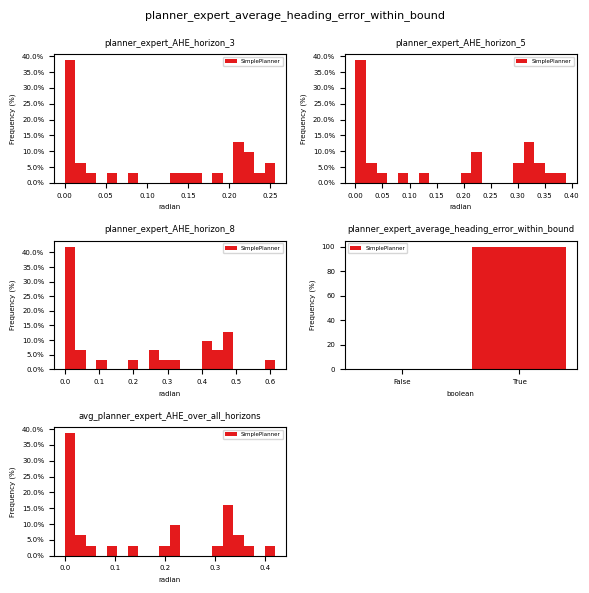

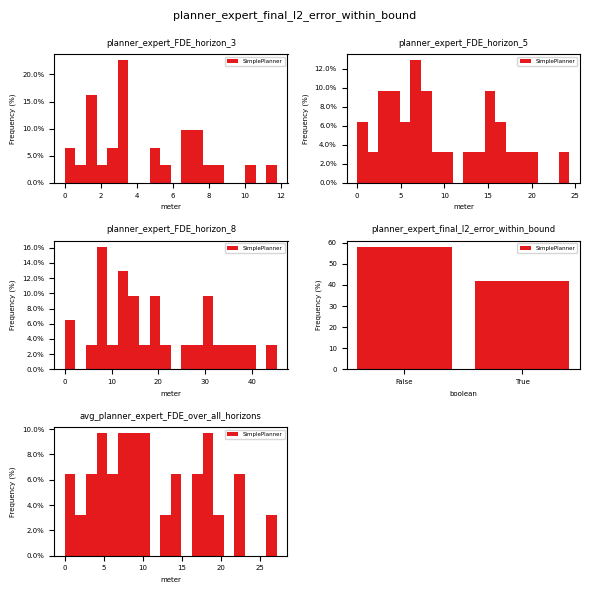

(raylet) [2023-04-15 22:03:51,668 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 736264192; capacity: 490577010688. Object creation will fail if spilling is required.


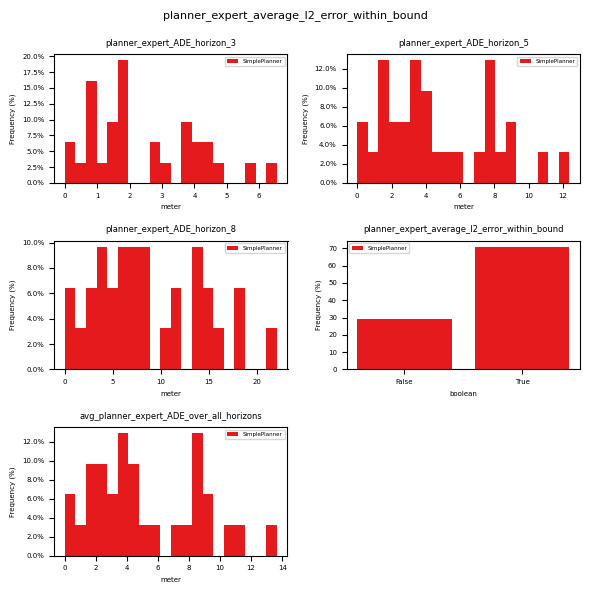

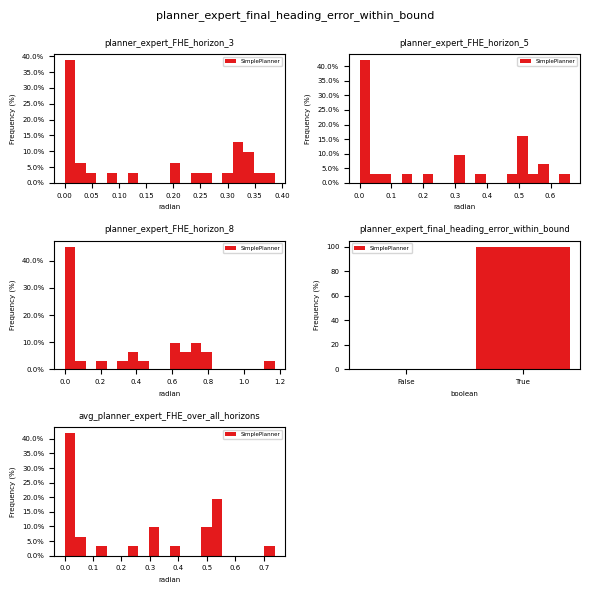

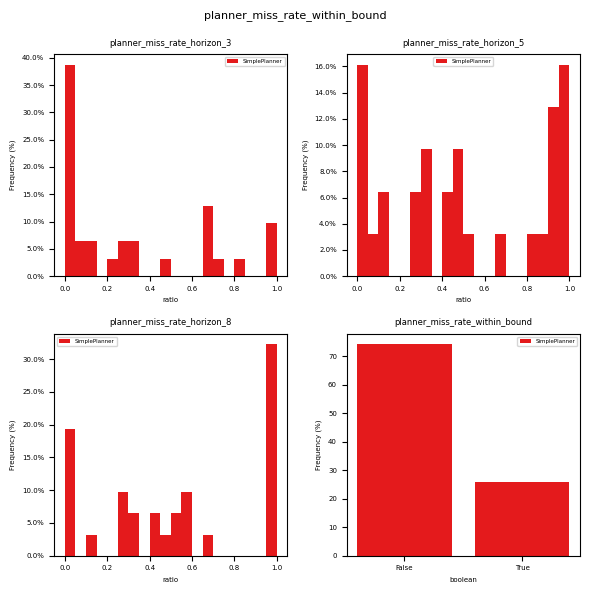

(raylet) [2023-04-15 22:04:01,675 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 736157696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:04:11,682 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 736149504; capacity: 490577010688. Object creation will fail if spilling is required.


In [7]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

## Launch simulation (command line - alternative)

A simulation experiment can be launched alternatively with:
```
$ python nuplan/planning/script/run_simulation.py \
    +simulation=open_loop_boxes \
    planner=simple_planner \
    scenario_builder=nuplan_mini \
    scenario_filter=all_scenarios \
    scenario_filter.scenario_types="[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]" \
    scenario_filter.num_scenarios_per_type=10 \
```

## Simulate a trained ML planner for comparison

Using the same simulation settings as before, we can simulate a pretrained ML planner and compare the two.

In this example you can take the model you trained earlier.

In [ ]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Get the checkpoint of the trained model
last_experiment = sorted(os.listdir(LOG_DIR))[-1]
train_experiment_dir = sorted(Path(LOG_DIR).iterdir())[-1]
checkpoint = sorted((train_experiment_dir / 'checkpoints').iterdir())[-1]

MODEL_PATH = str(checkpoint).replace("=", "\=")

# Name of the experiment
EXPERIMENT = 'simulation_raster_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    'planner=ml_planner',
    'model=raster_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={MODEL_PATH}',  # this path can be replaced by the checkpoint of the model trained in the previous section
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

# Run the simulation loop
main_simulation(cfg)

# ML_planner simulation folder for visualization in nuBoard (next section)
ml_planner_simulation_folder = cfg.output_dir

Global seed set to 0


2023-04-15 21:59:06,412 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-04-15 21:59:06,412 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-04-15 21:59:06,433 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-04-15 21:59:06,433 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-04-15 21:59:06,604 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-04-15 21:59:06,604 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-04-15 21:59:06,606 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreadi

2023-04-15 21:59:10,461	INFO worker.py:1553 -- Started a local Ray instance.


2023-04-15 21:59:11,424 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-04-15 21:59:11,424 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-04-15 21:59:11,425 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-04-15 21:59:11,425 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-04-15 21:59:11,425 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-04-15 21:59:11,425 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py


Ray objects: 100%|██████████████████████████████| 12/12 [00:08<00:00,  1.39it/s]


2023-04-15 21:59:20,089 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:55}  Extracting scenarios 31...DONE!
2023-04-15 21:59:20,089 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:55}  Extracting scenarios 31...DONE!
2023-04-15 21:59:20,090 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:59}  Building metric engines...
2023-04-15 21:59:20,090 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:59}  Building metric engines...
2023-04-15 21:59:20,122 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:61}  Building metric engines...DONE
2023-04-15 21:59:20,122 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:61}  Building metric engines...DONE
2023-04-15 21:59:20,123 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py

(raylet) [2023-04-15 21:59:20,341 E 157337 157355] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_21-59-08_239877_151727 is over 95% full, available space: 3929985024; capacity: 490577010688. Object creation will fail if spilling is required.


2023-04-15 21:59:21,036 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:21,036 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:21,293 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:21,293 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:21,335 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained

2023-04-15 21:59:24,482 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:24,482 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:24,700 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:24,700 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:24,722 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained

2023-04-15 21:59:27,916 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:27,916 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:28,132 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:28,132 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:28,198 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained

(raylet) [2023-04-15 21:59:30,345 E 157337 157355] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_21-59-08_239877_151727 is over 95% full, available space: 3929939968; capacity: 490577010688. Object creation will fail if spilling is required.


2023-04-15 21:59:30,520 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:30,520 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:30,735 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:30,735 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:30,759 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained

2023-04-15 21:59:34,249 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:34,249 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:34,465 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:34,465 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:34,489 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained

2023-04-15 21:59:37,933 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:37,933 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-04-15 21:59:38,145 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:38,145 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:247}  Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
2023-04-15 21:59:38,167 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/timm/models/helpers.py:275}  Converted input conv conv1 pretrained

(raylet) [2023-04-15 21:59:40,350 E 157337 157355] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_21-59-08_239877_151727 is over 95% full, available space: 3929763840; capacity: 490577010688. Object creation will fail if spilling is required.
2023-04-15 21:59:42,222	WARNING worker.py:1866 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 3d96a65e8e7b30a162b23382d97e7dea1b58a2a301000000 Worker ID: 4eb1492912e32a2f8858c6268df0186a64bf818858a8c0344da67cd2 Node ID: d5548659bf4799f8cb3316a769abd617589bd975b9c9435a5d50d626 Worker IP address: 192.168.0.128 Worker port: 44647 Worker PID: 158023 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned.
2023-04-15 21:59:42,391	WARNING worker.py:1866 -- A worker died or was killed while executing a task by an unexpected syste

# Visualizing metrics and scenarios <a name="dashboard"></a>

## nuBoard summary

Having trained and simulated planners across various scenarios and driving behaviors, it's time to evaluate them:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [9]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[simple_simulation_folder, ]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])

## Launch nuBoard (open in new tab - recommended)

In [10]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-04-15 22:07:08,569 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-04-15 22:07:08,580 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-04-15 22:07:08,581 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:70}  Opening Bokeh application on http://localhost:5006/
2023-04-15 22:07:08,581 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.2)
2023-04-15 22:07:08,582 WARNING {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly
2023-04-15 22:07:08,582 INFO {/home/vladislav/anacond

Found ffmpeg: /opt/yandex/browser/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[161558:161558:0415/220708.957955:ERROR:brand_package_util.cc(112)] Failed to verify partner_config signature, config will be ignored
[161558:161558:0415/220709.178502:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo
[161558:161558:0415/220709.178523:ERROR:child_process_security_policy_impl.cc(2011)] Invalid isolated origin: 


Окно или вкладка откроются в текущем сеансе браузера.
2023-04-15 22:07:09,379 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0011 seconds.


INFO:tornado.access:200 GET / (::1) 284.13ms


2023-04-15 22:07:09,519 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  200 GET / (::1) 284.13ms


INFO:tornado.access:101 GET /ws (::1) 0.48ms


2023-04-15 22:07:09,811 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  101 GET /ws (::1) 0.48ms
2023-04-15 22:07:09,811 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-04-15 22:07:09,812 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


(raylet) [2023-04-15 22:07:11,801 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 729845760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:07:21,808 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728780800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:07:31,816 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728686592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:07:41,823 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728670208; capacity: 490577010688. Object crea

2023-04-15 22:07:46,669 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 5.8035 seconds.


(raylet) [2023-04-15 22:07:51,827 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728580096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:08:01,833 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728494080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:08:11,839 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728453120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:08:21,846 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 728395776; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:13:02,044 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 719310848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:13:12,050 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 719302656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:13:22,057 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 719298560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:13:32,065 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 719286272; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:18:12,265 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965910528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:18:22,272 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965910528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:18:32,277 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965906432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:18:42,284 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965902336; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:23:22,484 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965939200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:23:32,492 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965939200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:23:42,499 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965935104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:23:52,506 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965910528; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:28:32,707 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965615616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:28:42,715 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965615616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:28:52,722 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965550080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:29:02,729 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965550080; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:33:42,919 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965271552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:33:52,926 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965197824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:34:02,934 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965189632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:34:12,942 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965177344; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:38:53,127 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964890624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:39:03,134 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964886528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:39:13,140 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964882432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:39:23,146 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964882432; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:44:03,330 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964382720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:44:13,337 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964378624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:44:23,344 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964378624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:44:33,351 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964378624; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:49:13,548 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964030464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:49:23,556 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964030464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:49:33,563 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964026368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:49:43,569 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964026368; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:54:23,770 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963715072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:54:33,777 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963715072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:54:43,785 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963710976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:54:53,792 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963641344; capacity: 490577010688. Object crea

(raylet) [2023-04-15 22:59:34,004 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963375104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:59:44,011 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963371008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 22:59:54,019 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963309568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:00:04,026 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963293184; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:04:44,226 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963039232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:04:54,232 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962990080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:05:04,238 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962990080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:05:14,245 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962977792; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:09:54,430 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962658304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:10:04,437 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962650112; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:10:14,444 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962646016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:10:24,451 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962641920; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:15:04,642 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962301952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:15:14,650 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962297856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:15:24,657 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962232320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:15:34,664 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962228224; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:20:14,865 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961921024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:20:24,872 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961896448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:20:34,879 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961896448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:20:44,886 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961892352; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:25:25,076 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961556480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:25:35,083 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961552384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:25:45,090 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961552384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:25:55,096 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961486848; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:30:35,279 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961200128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:30:45,285 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961196032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:30:55,292 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961159168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:31:05,298 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961155072; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:35:45,498 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960864256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:35:55,506 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960811008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:36:05,514 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960794624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:36:15,522 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960790528; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:40:55,736 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960475136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:41:05,744 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960462848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:41:15,751 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960462848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:41:25,759 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960458752; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:46:05,953 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960143360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:46:15,960 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960143360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:46:25,967 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960143360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:46:35,973 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960151552; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:51:16,175 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959795200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:51:26,182 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959791104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:51:36,190 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959799296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:51:46,196 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959799296; capacity: 490577010688. Object crea

(raylet) [2023-04-15 23:56:26,391 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959438848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:56:36,398 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959447040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:56:46,404 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959442944; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-15 23:56:56,411 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959418368; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:01:36,596 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1000112128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:01:46,603 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1000112128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:01:56,609 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1000046592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:02:06,616 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999972864; capacity: 490577010688. Object c

(raylet) [2023-04-16 00:06:36,810 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999546880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:06:46,818 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999542784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:06:56,825 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999481344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:07:06,832 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999464960; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:11:47,036 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999215104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:11:57,043 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999178240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:12:07,050 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999157760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:12:17,057 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 999165952; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:16:57,261 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998879232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:17:07,268 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998850560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:17:17,276 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998850560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:17:27,283 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998846464; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:22:07,484 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998506496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:22:17,491 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998518784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:22:27,497 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998518784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:22:37,504 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998522880; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:27:17,713 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998207488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:27:27,721 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998203392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:27:37,728 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998199296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:27:47,736 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 998199296; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:32:27,951 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997851136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:32:37,959 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997863424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:32:47,967 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997859328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:32:57,975 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997793792; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:37:38,192 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997515264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:37:48,199 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997515264; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:37:58,207 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997474304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:38:08,214 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997466112; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:42:48,430 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997191680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:42:58,438 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997142528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:43:08,445 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997138432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:43:18,453 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 997138432; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:47:58,643 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996794368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:48:08,649 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996790272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:48:18,656 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996782080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:48:28,662 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996782080; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:53:08,850 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996466688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:53:18,857 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996466688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:53:28,865 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996462592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:53:38,872 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996462592; capacity: 490577010688. Object crea

(raylet) [2023-04-16 00:58:19,085 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996126720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:58:29,093 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996114432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:58:39,101 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996110336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 00:58:49,108 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 996110336; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:03:29,318 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995815424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:03:39,325 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995811328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:03:49,333 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995807232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:03:59,340 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995782656; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:08:39,545 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995479552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:08:49,552 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995479552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:08:59,560 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995434496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:09:09,567 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995434496; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:13:49,780 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995164160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:13:59,787 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995102720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:14:09,795 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995098624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:14:19,803 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 995098624; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:18:59,996 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994754560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:19:10,003 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994738176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:19:20,010 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994738176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:19:30,016 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994738176; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:24:10,204 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994410496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:24:20,212 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994406400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:24:30,220 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994418688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:24:40,228 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994406400; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:29:20,431 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994078720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:29:30,438 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994074624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:29:40,446 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994086912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:29:50,453 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 994078720; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:34:30,657 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993742848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:34:40,664 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993742848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:34:50,671 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993734656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:35:00,679 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993710080; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:39:40,868 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993599488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:39:50,875 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993591296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:40:00,882 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993521664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:40:10,888 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993513472; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:44:51,076 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993255424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:45:01,083 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993193984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:45:11,090 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993206272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:45:21,096 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 993206272; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:50:01,284 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992874496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:50:11,290 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992870400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:50:21,297 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992870400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:50:31,303 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992866304; capacity: 490577010688. Object crea

(raylet) [2023-04-16 01:55:11,503 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992538624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:55:21,510 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992534528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:55:31,518 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992534528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 01:55:41,526 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992530432; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:00:21,746 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992178176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:00:31,753 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992178176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:00:41,761 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992178176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:00:51,768 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 992165888; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:05:31,957 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991862784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:05:41,963 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991862784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:05:51,970 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991862784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:06:01,977 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991801344; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:10:42,165 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991535104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:10:52,173 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991510528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:11:02,180 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991457280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:11:12,187 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991449088; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:15:52,391 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 991166464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:16:02,398 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988766208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:16:12,406 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988766208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:16:22,414 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988762112; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:21:02,608 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988409856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:21:12,616 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988409856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:21:22,622 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988409856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:21:32,629 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 970448896; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:26:12,834 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988086272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:26:22,842 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988082176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:26:32,849 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988078080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:26:42,859 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 988078080; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:31:23,077 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987762688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:31:33,084 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987762688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:31:43,091 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987758592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:31:53,099 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987734016; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:36:33,316 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987426816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:36:43,324 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987426816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:36:53,333 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987357184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:37:03,342 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987357184; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:41:43,559 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987086848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:41:53,567 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987058176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:42:03,574 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987049984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:42:13,582 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987017216; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:46:53,795 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986681344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:47:03,801 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986669056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:47:13,807 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986652672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:47:23,814 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986652672; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:52:03,998 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986308608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:52:14,005 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986320896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:52:24,012 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986329088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:52:34,018 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986329088; capacity: 490577010688. Object crea

(raylet) [2023-04-16 02:57:14,227 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986009600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:57:24,235 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986009600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:57:34,243 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986017792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 02:57:44,252 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 986017792; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:02:24,452 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985661440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:02:34,459 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985669632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:02:44,466 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985669632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:02:54,473 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985608192; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:07:34,673 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985325568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:07:44,680 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985321472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:07:54,687 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985288704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:08:04,693 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985272320; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:12:44,878 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 985014272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:12:54,885 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984956928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:13:04,893 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984944640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:13:14,901 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984944640; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:17:55,107 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984514560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:18:05,114 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984502272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:18:15,120 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984502272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:18:25,127 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984498176; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:23:05,313 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984260608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:23:15,321 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984244224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:23:25,328 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984231936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:23:35,337 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984227840; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:28:15,548 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983920640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:28:25,555 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983916544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:28:35,562 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983916544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:28:45,569 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983904256; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:33:25,756 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983613440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:33:35,763 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983609344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:33:45,770 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983609344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:33:55,777 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983576576; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:38:35,972 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983293952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:38:45,979 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983289856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:38:55,985 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983224320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:39:05,992 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983220224; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:43:46,181 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982966272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:43:56,189 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982904832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:44:06,196 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982900736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:44:16,203 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982896640; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:48:56,411 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982560768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:49:06,419 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982560768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:49:16,426 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982560768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:49:26,433 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982556672; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:54:06,636 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982220800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:54:16,644 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982220800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:54:26,651 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982220800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:54:36,657 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982216704; capacity: 490577010688. Object crea

(raylet) [2023-04-16 03:59:16,859 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981889024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:59:26,867 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981889024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:59:36,874 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981889024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 03:59:46,882 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981872640; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:04:27,079 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981557248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:04:37,086 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981557248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:04:47,093 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981544960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:04:57,099 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981483520; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:09:37,314 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981221376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:09:47,322 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981217280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:09:57,330 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981143552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:10:07,338 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981135360; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:14:47,554 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980885504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:14:57,561 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980840448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:15:07,567 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980836352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:15:17,574 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980832256; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:19:57,762 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980492288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:20:07,769 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980488192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:20:17,776 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980484096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:20:27,784 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980484096; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:25:08,011 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987033600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:25:18,019 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987033600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:25:28,027 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987029504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:25:38,035 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 987029504; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:30:18,262 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984178688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:30:28,270 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984178688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:30:38,279 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984174592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:30:48,287 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 984174592; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:35:28,494 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983834624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:35:38,501 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983846912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:35:48,509 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983855104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:35:58,516 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983793664; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:40:38,721 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983523328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:40:48,728 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983523328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:40:58,734 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983461888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:41:08,742 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983461888; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:45:48,944 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983187456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:45:58,951 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983142400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:46:08,958 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983126016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:46:18,965 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 983121920; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:50:59,170 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982798336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:51:09,178 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982794240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:51:19,185 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982794240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:51:29,193 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982790144; capacity: 490577010688. Object crea

(raylet) [2023-04-16 04:56:09,395 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982458368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:56:19,402 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982454272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:56:29,410 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982454272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 04:56:39,417 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982466560; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:01:19,615 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982077440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:01:29,622 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982081536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:01:39,628 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982081536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:01:49,636 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 982077440; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:06:29,837 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981786624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:06:39,845 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981782528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:06:49,852 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981770240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:06:59,860 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981721088; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:11:40,075 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981450752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:11:50,082 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981438464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:12:00,090 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981401600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:12:10,098 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981389312; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:16:50,306 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981143552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:17:00,313 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981086208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:17:10,321 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981073920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:17:20,328 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 981053440; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:22:00,535 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980742144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:22:10,543 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980738048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:22:20,550 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980738048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:22:30,557 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980746240; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:27:10,761 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980414464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:27:20,768 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980414464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:27:30,776 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980414464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:27:40,783 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980410368; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:32:20,989 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980054016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:32:30,997 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980066304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:32:41,004 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980078592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:32:51,011 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 980066304; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:37:31,216 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979722240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:37:41,223 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979722240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:37:51,231 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979718144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:38:01,239 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979685376; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:42:41,427 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979419136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:42:51,434 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979415040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:43:01,441 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979365888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:43:11,449 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979361792; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:47:51,690 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979054592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:48:01,698 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 979001344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:48:11,705 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978997248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:48:21,712 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978993152; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:53:01,898 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978685952; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:53:11,906 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978669568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:53:21,913 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978677760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:53:31,921 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978677760; capacity: 490577010688. Object crea

(raylet) [2023-04-16 05:58:12,132 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978354176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:58:22,140 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978354176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:58:32,147 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978350080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 05:58:42,153 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978345984; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:03:22,359 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 978022400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:03:32,366 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977813504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:03:42,374 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977809408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:03:52,381 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977801216; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:08:32,586 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977473536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:08:42,593 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977473536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:08:52,600 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977448960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:09:02,608 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977416192; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:13:42,813 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977162240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:13:52,821 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977133568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:14:02,829 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977084416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:14:12,836 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 977084416; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:18:43,036 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086398464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:18:53,043 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086377984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:19:03,050 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086361600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:19:13,058 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086353408; capacity: 490577010688. Object 

(raylet) [2023-04-16 06:23:43,258 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086078976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:23:53,265 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086054400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:24:03,273 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086021632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:24:13,280 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1086021632; capacity: 490577010688. Object 

(raylet) [2023-04-16 06:28:43,491 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1085755392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:28:53,498 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1085726720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:29:03,506 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1085677568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:29:13,513 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 1085677568; capacity: 490577010688. Object 

(raylet) [2023-04-16 06:33:43,724 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975986688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:33:53,730 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975966208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:34:03,737 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975941632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:34:13,743 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975937536; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:38:53,931 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975630336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:39:03,938 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975601664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:39:13,945 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975601664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:39:23,952 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975593472; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:44:04,143 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975257600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:44:14,150 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975257600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:44:24,158 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975253504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:44:34,166 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 975265792; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:49:14,380 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974929920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:49:24,388 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974929920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:49:34,397 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974925824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:49:44,405 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974925824; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:54:24,622 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974585856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:54:34,630 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974585856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:54:44,638 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974594048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:54:54,645 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974528512; capacity: 490577010688. Object crea

(raylet) [2023-04-16 06:59:34,852 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974254080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:59:44,858 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974254080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 06:59:54,865 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974213120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:00:04,871 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974184448; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:04:45,075 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973893632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:04:55,082 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973848576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:05:05,090 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973844480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:05:15,096 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973832192; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:09:55,281 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973496320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:10:05,288 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973492224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:10:15,294 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973488128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:10:25,301 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973488128; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:15:05,500 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973185024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:15:15,507 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973185024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:15:25,514 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973180928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:15:35,522 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 973176832; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:20:15,727 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972836864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:20:25,735 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972832768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:20:35,742 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972832768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:20:45,749 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972832768; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:25:25,956 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972496896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:25:35,963 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972492800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:25:45,971 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972488704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:25:55,978 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972447744; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:30:36,182 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972152832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:30:46,188 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972148736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:30:56,195 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972103680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:31:06,201 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 972099584; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:35:46,410 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 971825152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:35:56,416 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 971763712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:36:06,423 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 971759616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:36:16,430 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 971759616; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:40:56,616 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974778368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:41:06,622 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974774272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:41:16,629 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974774272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:41:26,636 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974774272; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:46:06,840 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974442496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:46:16,848 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974438400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:46:26,856 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974438400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:46:36,863 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 974430208; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:51:17,100 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965652480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:51:27,108 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965660672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:51:37,116 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965660672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:51:47,124 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965656576; capacity: 490577010688. Object crea

(raylet) [2023-04-16 07:56:27,344 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965341184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:56:37,351 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965341184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:56:47,359 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965341184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 07:56:57,366 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965283840; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:01:37,609 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965001216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:01:47,617 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964997120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:01:57,624 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964939776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:02:07,632 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964919296; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:06:47,849 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964661248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:06:57,856 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964599808; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:07:07,864 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964587520; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:07:17,871 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964583424; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:11:58,071 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964280320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:12:08,077 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964276224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:12:18,084 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964276224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:12:28,091 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964272128; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:17:08,308 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965828608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:17:18,316 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965816320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:17:28,324 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965808128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:17:38,333 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965816320; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:22:18,552 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965480448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:22:28,558 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965480448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:22:38,564 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965492736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:22:48,571 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965496832; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:27:28,787 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965173248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:27:38,795 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965173248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:27:48,803 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965169152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:27:58,811 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 965115904; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:32:39,033 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964841472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:32:49,041 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964841472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:32:59,049 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964784128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:33:09,057 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964784128; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:37:49,277 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964497408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:37:59,284 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964452352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:38:09,292 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964448256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:38:19,299 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964448256; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:42:59,506 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964128768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:43:09,513 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964128768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:43:19,520 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964124672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:43:29,527 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 964112384; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:48:09,728 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963764224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:48:19,735 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963764224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:48:29,742 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963756032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:48:39,749 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963756032; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:53:19,947 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963436544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:53:29,955 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963436544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:53:39,962 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963444736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:53:49,969 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963428352; capacity: 490577010688. Object crea

(raylet) [2023-04-16 08:58:30,166 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963112960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:58:40,173 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963112960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:58:50,180 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963100672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 08:59:00,187 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 963059712; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:03:40,379 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962777088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:03:50,387 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962768896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:04:00,395 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962723840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:04:10,402 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962711552; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:08:50,611 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962449408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:09:00,618 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962379776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:09:10,625 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962375680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:09:20,632 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962375680; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:14:00,838 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962056192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:14:10,845 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962064384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:14:20,853 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962064384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:14:30,860 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 962060288; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:19:11,069 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961728512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:19:21,076 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961724416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:19:31,083 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961724416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:19:41,091 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961720320; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:24:21,297 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961388544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:24:31,304 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961384448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:24:41,312 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961384448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:24:51,319 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961376256; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:29:31,516 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961040384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:29:41,523 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961036288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:29:51,530 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 961032192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:30:01,536 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960983040; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:34:41,733 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960679936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:34:51,741 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960667648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:35:01,748 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960610304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:35:11,756 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960606208; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:39:51,963 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960323584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:40:01,971 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960274432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:40:11,979 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960274432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:40:21,986 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960270336; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:45:02,201 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960004096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:45:12,209 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960004096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:45:22,217 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960004096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:45:32,225 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 960000000; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:50:12,417 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959610880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:50:22,424 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959606784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:50:32,430 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959606784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:50:42,437 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959602688; capacity: 490577010688. Object crea

(raylet) [2023-04-16 09:55:22,642 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959311872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:55:32,650 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959307776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:55:42,658 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959307776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 09:55:52,665 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 959299584; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:00:32,860 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958976000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:00:42,866 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958971904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:00:52,872 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958943232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:01:02,880 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958914560; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:05:43,088 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958644224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:05:53,095 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958619648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:06:03,103 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958570496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:06:13,112 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958562304; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:10:53,327 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958279680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:11:03,335 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958267392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:11:13,343 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958263296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:11:23,351 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958263296; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:16:03,566 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957956096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:16:13,574 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958140416; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:16:23,582 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958136320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:16:33,589 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 958136320; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:21:13,809 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957792256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:21:23,817 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957792256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:21:33,825 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957800448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:21:43,833 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957800448; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:26:24,075 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957468672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:26:34,083 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957480960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:26:44,091 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957476864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:26:54,099 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957452288; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:31:34,319 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957157376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:31:44,327 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957157376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:31:54,335 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957128704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:32:04,343 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 957071360; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:36:44,557 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956817408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:36:54,564 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956792832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:37:04,571 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956751872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:37:14,579 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956747776; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:41:54,794 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956444672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:42:04,800 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956403712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:42:14,807 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956399616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:42:24,813 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956399616; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:47:05,018 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956067840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:47:15,024 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956063744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:47:25,031 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956051456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:47:35,039 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 956063744; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:52:15,251 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955752448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:52:25,259 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955703296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:52:35,266 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955752448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:52:45,274 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955752448; capacity: 490577010688. Object crea

(raylet) [2023-04-16 10:57:25,468 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955420672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:57:35,474 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955416576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:57:45,481 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955416576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 10:57:55,487 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955392000; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:02:35,676 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955088896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:02:45,682 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955084800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:02:55,689 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955056128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:03:05,697 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 955027456; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:07:45,903 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954736640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:07:55,910 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954691584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:08:05,917 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954687488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:08:15,925 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954687488; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:12:56,138 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954359808; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:13:06,145 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954355712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:13:16,153 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954355712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:13:26,160 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 954351616; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:18:06,379 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953978880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:18:16,387 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953974784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:18:26,395 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953974784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:18:36,402 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953970688; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:23:16,591 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953638912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:23:26,598 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 920928256; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:23:36,606 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953630720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:23:46,614 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953626624; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:28:26,818 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953286656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:28:36,826 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953286656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:28:46,833 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953286656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:28:56,841 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 953241600; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:33:37,051 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952930304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:33:47,058 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952930304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:33:57,066 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952877056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:34:07,073 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952868864; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:38:47,279 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952578048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:38:57,287 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952528896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:39:07,294 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952524800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:39:17,302 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952524800; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:43:57,507 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952205312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:44:07,515 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952201216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:44:17,522 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952197120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:44:27,529 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 952193024; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:49:07,735 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951865344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:49:17,742 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951861248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:49:27,750 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951861248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:49:37,756 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951857152; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:54:17,950 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951521280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:54:27,957 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951521280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:54:37,964 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951517184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:54:47,972 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951517184; capacity: 490577010688. Object crea

(raylet) [2023-04-16 11:59:28,174 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951185408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:59:38,181 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951197696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:59:48,188 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951193600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 11:59:58,195 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 951132160; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:04:38,398 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950743040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:04:48,405 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950743040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:04:58,412 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950669312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:05:08,420 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950669312; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:09:48,625 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950394880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:09:58,631 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950349824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:10:08,638 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950329344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:10:18,645 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950329344; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:14:58,850 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 950009856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:15:08,858 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949997568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:15:18,865 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949993472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:15:28,873 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949993472; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:20:09,079 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949657600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:20:19,086 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949653504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:20:29,093 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949649408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:20:39,100 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949649408; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:25:19,291 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949329920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:25:29,299 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949329920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:25:39,307 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949325824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:25:49,315 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 949325824; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:30:29,536 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948994048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:30:39,544 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948977664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:30:49,551 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948977664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:30:59,558 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948916224; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:35:39,767 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948666368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:35:49,774 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948662272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:35:59,782 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948604928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:36:09,789 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948604928; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:40:49,998 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948879360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:41:00,007 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948834304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:41:10,014 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948834304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:41:20,022 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948834304; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:46:00,232 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948490240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:46:10,239 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948486144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:46:20,247 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948486144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:46:30,254 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948482048; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:51:10,466 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948158464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:51:20,474 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948154368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:51:30,482 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948150272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:51:40,490 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 948146176; capacity: 490577010688. Object crea

(raylet) [2023-04-16 12:56:20,690 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 947802112; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:56:30,696 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 947830784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:56:40,702 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 947945472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-04-16 12:56:50,709 E 160478 160496] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-04-15_22-02-49_421469_158407 is over 95% full, available space: 947896320; capacity: 490577010688. Object crea

## Launch nuBoard (embedded within the notebook - alternative)

In [ ]:
from bokeh.io import show, output_notebook
from nuplan.planning.script.run_nuboard import initialize_nuboard

# Make sure that the notebook working directory is "/notebooks" and that Jupyter was launched at the root of the repo
cfg.resource_prefix = '/notebooks/nuplan/planning/metrics/board/'  # pass CSS resources to the notebook

# Run the nuBoard
output_notebook()
nuboard = initialize_nuboard(cfg)
show(nuboard.main_page)

## Launch nuBoard (command line - alternative)

nuBoard can be launched alternatively with:
```
$ python nuplan/planning/script/run_nuboard.py
```

Simulation files (.nuboard) can be selected under the configuration tab.